## Tiltmeter - ALL - TemperatureCorrection - Longterm

### Import Libraries

In [2]:
import os
import yaml
import matplotlib.pyplot as plt

from numpy import array
from pandas import read_csv, DataFrame, date_range
from obspy import UTCDateTime, read, Stream

from andbro__readYaml import __readYaml
from andbro__savefig import __savefig

In [3]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

### Define Functions

In [4]:
def __makeplot(pt, bt, config):
    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    pt.sort()
    bt.sort()

    for i in range(3):
        
        axes[i,0].plot(pt[i].times()/3600, pt[i].data, label=pt[i].stats.channel)
        axes[i,1].plot(bt[i].times()/3600, bt[i].data, label=pt[i].stats.channel)
        
        axes[i,0].grid()
        axes[i,1].grid()
        
        axes[i,0].legend()
        axes[i,1].legend()
        
        axes[i,0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axes[i,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    axes[2,0].ticklabel_format(axis="y", style="plain")
    axes[2,1].ticklabel_format(axis="y", style="plain")    
        
    axes[2,0].set_xlabel("Time (hours)")
    axes[2,1].set_xlabel("Time (hours)")
    
    axes[0,0].set_ylabel("E (rad)")
    axes[1,0].set_ylabel("N (rad)")
    axes[2,0].set_ylabel("Temp (°C)")
    
    axes[0,0].set_title(f"{pt[0].stats.station}")
    axes[0,1].set_title(f"{bt[0].stats.station}")
    
    return fig 

In [5]:
def __conversion(st, conf):

    st0 = st.copy()
    
    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3
    
    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")
            
    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [6]:
def __load_local(config, seed_id):
    
    from tqdm.notebook import tqdm
    from obspy.clients.filesystem.sds import Client
    
    st = Stream()
    for date in tqdm(date_range(str(config['tbeg']), str(config['tend']))):
        tbeg = UTCDateTime(date)

        doy  = str(tbeg.julday).rjust(3,"0")
        year = str(tbeg.year)
        net, sta, loc, cha = seed_id.split(".")

        for c in ['N','E','T']:
            filename = f"{net}.{sta}.{loc}.{cha[:-1]}{c}.D.{year}.{doy}"
                
            st0 = Client(config['datapath'],fileborder_samples=1000).get_waveforms(net, sta, loc, cha, tbeg-1000, tbeg+86400)
#             st0 = read(config['datapath']+year+"/"+net+"/"+sta+"/"+cha[:-1]+c+".D/"+filename)
            
            
#             st0.resample(config['resample_rate'])
#             st0.decimate(10, strict_length=False, no_filter=True)
    
            st += st0

        st.merge()
    return st

In [87]:
def __smooth(y, box_pts):
    from numpy import ones, convolve, hanning

#     win = ones(box_pts)/box_pts
    win = hanning(box_pts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    return y_smooth

### Configurations

In [8]:
## configurations
config={}

config['save'] = False

# config['seed_id'] = ["BW.TROMY..MA*", "BW.TROMY..MA*"]

## indicate path to downsampled tiltmeter data
config['datapath'] = f"{data_path}TiltmeterDataBackup/Tilt_downsampled"

## indicate path to wromy data
config['pathToWromy'] = f"{data_path}wromy/"

## define output path for figures
config['output_figures'] = f"{root_path}Documents/ROMY/tiltmeter/figures/"

## time selection
config['tbeg'] = UTCDateTime("2022-04-24 00:00")
# config['tend'] = UTCDateTime("2022-05-31 00:00")
config['tend'] = UTCDateTime("2022-06-12 00:00")

## entire year
# config['tbeg'] = UTCDateTime("2021-09-01 00:00")
# config['tend'] = UTCDateTime("2022-08-31 00:00")

## gain for Temperature channel of PT was not set correctly prior to 2021-03-03
correct_settings_temp_PT = ("2021-03-05", config['tend'])

In [9]:
## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter.conf")


### Load Tiltmeter Data

  0%|          | 0/50 [00:00<?, ?it/s]

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-23T23:40:00.040000Z - 2022-06-12T23:50:00.040000Z | 600.0 s, 7202 samples
BW.TROMY..MAN | 2022-04-23T23:40:00.039999Z - 2022-06-12T23:50:00.039999Z | 600.0 s, 7202 samples
BW.TROMY..MAT | 2022-04-23T23:40:00.039999Z - 2022-06-12T23:50:00.039999Z | 600.0 s, 7202 samples


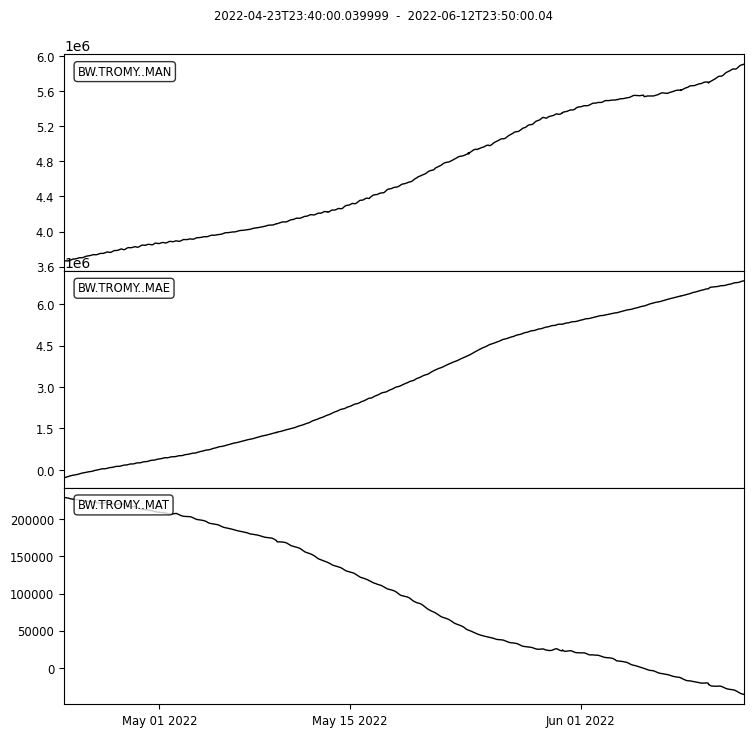

In [10]:
TROMY0 = __load_local(config, "BW.TROMY..MA*")
TROMY0.sort()
print(TROMY0)
TROMY0.plot(equal_scale=False);

  0%|          | 0/50 [00:00<?, ?it/s]

3 Trace(s) in Stream:
BW.ROMYT..MAE | 2022-04-23T23:39:59.940000Z - 2022-06-12T23:59:59.940000Z | 600.0 s, 7203 samples
BW.ROMYT..MAN | 2022-04-23T23:39:59.940000Z - 2022-06-12T23:59:59.940000Z | 600.0 s, 7203 samples
BW.ROMYT..MAT | 2022-04-23T23:39:59.940000Z - 2022-06-12T23:59:59.940000Z | 600.0 s, 7203 samples


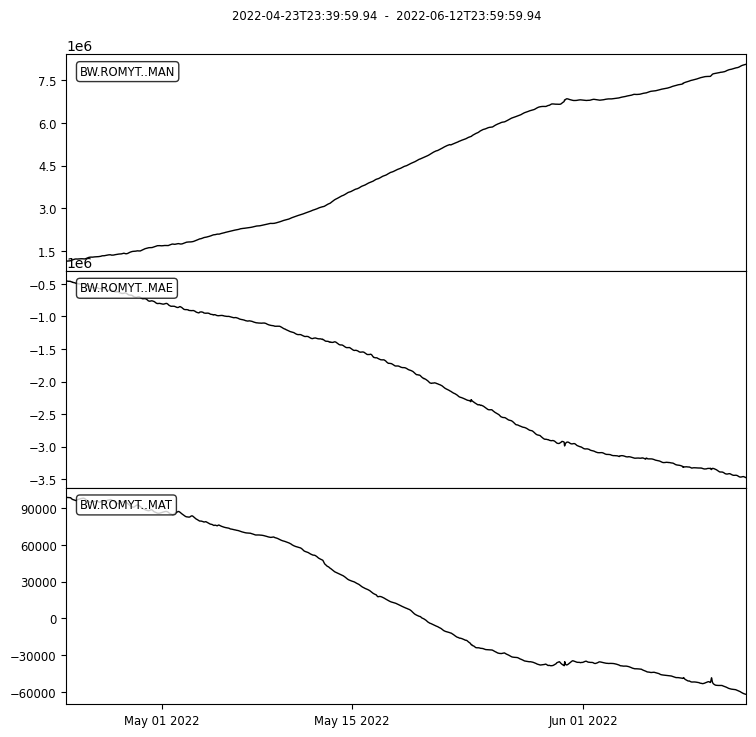

In [11]:
ROMYT0 = __load_local(config, "BW.ROMYT..MA*")
ROMYT0.sort()
print(ROMYT0)
ROMYT0.plot(equal_scale=False);

  0%|          | 0/50 [00:00<?, ?it/s]

3 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-23T23:40:00.000000Z - 2022-06-13T00:00:00.000000Z | 600.0 s, 7203 samples (masked)
BW.DROMY..LAN | 2022-04-23T23:40:00.000000Z - 2022-06-13T00:00:00.000000Z | 600.0 s, 7203 samples (masked)
BW.DROMY..LAT | 2022-04-23T23:40:00.000000Z - 2022-06-13T00:00:00.000000Z | 600.0 s, 7203 samples (masked)


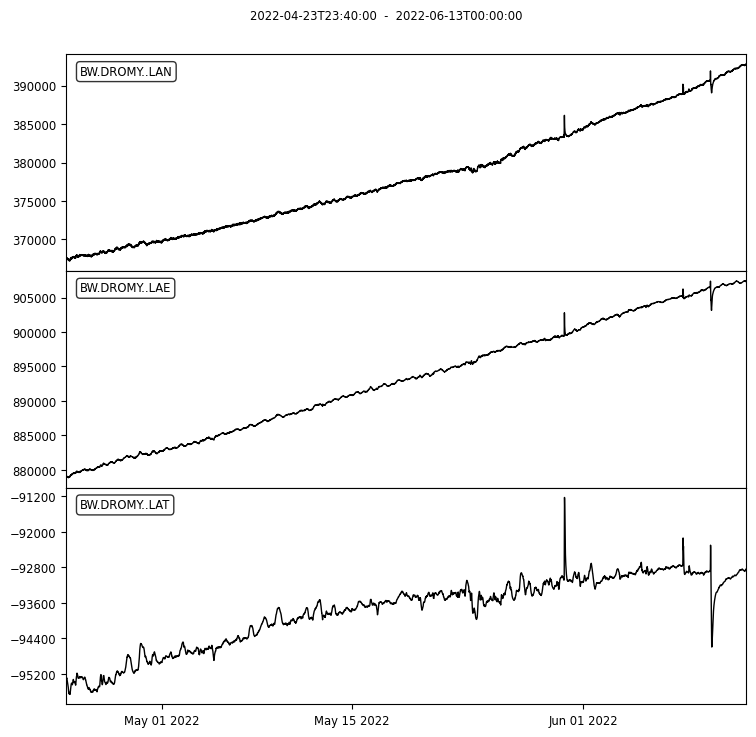

In [12]:
BROMY0 = __load_local(config, "BW.DROMY..LA*")
BROMY0.sort()
print(BROMY0)
BROMY0.plot(equal_scale=False);

### Data Conversion to rad

In [34]:
TROMY = __conversion(TROMY0, confTilt['TROMY'])
ROMYT = __conversion(ROMYT0, confTilt['ROMYT'])
BROMY = __conversion(BROMY0, confTilt['BROMY'])

  -> converted data of TROMY
  -> converted data of ROMYT
  -> converted data of DROMY


In [35]:
from numpy import nan
BROMY 
# BROMY = BROMY.split().merge(fill_value=nan)
BROMY = BROMY.split().merge(fill_value="interpolate")
BROMY

3 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-23T23:40:00.000000Z - 2022-06-13T00:00:00.000000Z | 600.0 s, 7203 samples (masked)
BW.DROMY..LAN | 2022-04-23T23:40:00.000000Z - 2022-06-13T00:00:00.000000Z | 600.0 s, 7203 samples (masked)
BW.DROMY..LAT | 2022-04-23T23:40:00.000000Z - 2022-06-13T00:00:00.000000Z | 600.0 s, 7203 samples (masked)

3 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-23T23:40:00.000000Z - 2022-06-12T23:50:00.000000Z | 600.0 s, 7202 samples
BW.DROMY..LAN | 2022-04-23T23:40:00.000000Z - 2022-06-12T23:50:00.000000Z | 600.0 s, 7202 samples
BW.DROMY..LAT | 2022-04-23T23:40:00.000000Z - 2022-06-12T23:50:00.000000Z | 600.0 s, 7202 samples

3592


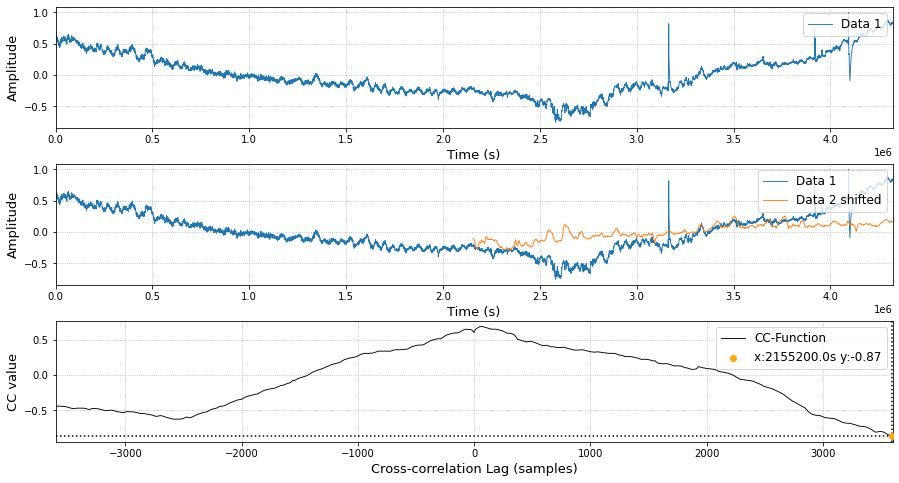

Maximum Correlation: 
 x: 3592 
 y: -0.87


{'ccorr': array([-0.43816722, -0.4387898 , -0.43942249, ..., -0.86570707,
        -0.86525348, -0.86479044]),
 'xlags': array([-3601, -3600, -3599, ...,  3598,  3599,  3600]),
 'maximum': (3592, -0.86703623344856595),
 'figure': <Figure size 1080x576 with 3 Axes>}

In [38]:
# from andbro__crosscorrelation import __crosscorrelation

# n = BROMY.copy().select(channel="*N").split().detrend("linear").merge(fill_value=0)[0].data
# t = BROMY.copy().select(channel="*T").split().detrend("linear").merge(fill_value=0)[0].data

# __crosscorrelation(n/max(n),t/max(t), deltaT=BROMY[0].stats.delta)

### Load WROMY Data

In [39]:
def __load_wromy_data(channel, config):
    
    from os import listdir
    from tqdm.notebook import tqdm
    from pandas import read_pickle, concat

    files = listdir(config['pathToWromy']+channel)
    
    for n, file in enumerate(tqdm(files)):
        df0 = read_pickle(config['pathToWromy']+channel+"/"+file)
        if n == 0:
            df_raw = df0
        else: 
            df_raw = concat([df_raw,df0])
    df_raw.reset_index()
    return df_raw

In [40]:
def __add_wromy_trace(stream, ws):

    from numpy import nan
    
    df0 = __load_wromy_data(ws, config)
    df0.dropna(inplace=True)
    df0.sort_values('TimeStamp', inplace=True)
    df0.reset_index(drop=True, inplace=True)
    wsx = df0
    
    
    ## limit to tbeg - tend
    times_absolut = stream.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01"))
    wsx = wsx[(wsx['totalSeconds'] >= times_absolut[0]) & (wsx['totalSeconds'] <= times_absolut[-1]+500)]
    
    
    if len(wsx['totalSeconds']) != stream[0].stats.npts:
        print(f"-> npts don't match: {len(wsx['totalSeconds'])} != {stream[0].stats.npts}")
    
    ## create trace and addto stream
    tr_wsx = stream.select(channel="*T")[0].copy()
    tr_wsx.data = array(wsx['Temperature (°C)'])
    tr_wsx.stats.channel = ws
    stream += tr_wsx

In [41]:
__add_wromy_trace(ROMYT, "WS9")
__add_wromy_trace(TROMY, "WS5")
__add_wromy_trace(BROMY, "WS1")

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

In [42]:
def __plot_all_tilt(st1, st2, st3):

    from datetime import datetime
    
    NN=3
    
    fig, ax = plt.subplots(NN,1, figsize=(15,8), sharex=True)

    font = 14
    
    tilt_scaling, tilt_unit = 1e-6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"
    
    ax[0].plot(st1.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*N")[0].data/tilt_scaling, label="TROMY")
    ax[0].plot(st2.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*N")[0].data/tilt_scaling, label="ROMYT")
    ax[0].plot(st3.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*N")[0].data/tilt_scaling, label="BROMY")

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st2.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st3.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*E")[0].data/tilt_scaling)

    ax[2].plot(st1.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*T")[0].data)
    ax[2].plot(st2.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*T")[0].data)
    ax[2].plot(st3.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*T")[0].data)

    ax[0].set_ylabel(f"N ({tilt_unit})", fontsize=font)
    ax[1].set_ylabel(f"E ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"T (°C)", fontsize=font)
#     ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    for o in range(3):
        ax[o].grid()
    
    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.7, 1.1), ncol=3, framealpha=1)
    
    tcks= ax[NN-1].get_xticks()
    tcklbls = [datetime.fromtimestamp(t*time_scaling+datetime(2019,1,1).timestamp()).strftime("%Y-%m-%d") for t in tcks]
    ax[NN-1].set_xticklabels(tcklbls)
    
    plt.show();
    return fig

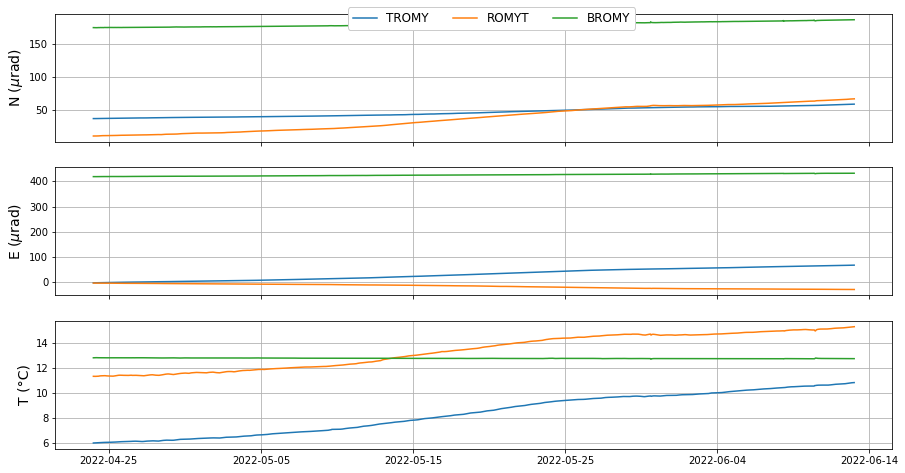

In [43]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)   

## Reset to zero tilt at start

In [45]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= tr.data[1]

## Get Temperature Coefficients

In [46]:
# for tr in TROMY:
#     tr.taper(0.1)
#     tr.filter("lowpass", freq=1/(2*86400), corners=4, zerophase=True)
# TROMY.trim(config['tbeg']+5*86400, config['tend']-5*86400)

In [47]:
def __makeplot_compare(st, slopes, intercepts, derive=None, poly=None, smooth=None, coeff=None, relative=None):
    
    from numpy import gradient
    
    N_trace = st.select(channel="*N")[0]
    E_trace = st.select(channel="*E")[0]
    T_trace = st.select(channel="*T")[0]
    
    ## relative Temperatures
    
    if derive:
        x_temp = gradient(T_trace.data, 2)
    else:
        x_temp = T_trace.data     
        
    if smooth:
        x_temp = __smooth(x_temp, smooth)

    if relative:
        x_temp -= x_temp[1]
        T_trace.data -= T_trace.data[1]

    
    fig, ax = plt.subplots(3, 2, figsize=(15,10))

    plt.subplots_adjust(hspace=0.3)
    
    ax[0][0].plot(T_trace.times()/86400, T_trace.data, label="Temperature")
    
    if derive:
        axes1 = ax[0][0].twinx()
        axes1.plot(T_trace.times()/86400, x_temp, 'g', label="dT/dt")
    
    ax[0][1].plot(T_trace.times()/86400, T_trace.data, label="Temperature")
    
    if derive:
        axes2 = ax[0][1].twinx()
        axes2.plot(T_trace.times()/86400, x_temp, 'g', label="dT/dt")
    
    for i in range(2):
        
        if i == 0: 
            trace = N_trace
        elif i == 1:
            trace = E_trace
        
        ax[1][i].plot(x_temp, trace.data, 'k.', ms=0.2)

        if not poly:        
            ax[1][i].plot(x_temp, slopes[i]*x_temp + intercepts[i], 'r', label=f"{slopes[i]:.2e}*x")
#             correction = slopes[i] * x_temp

#             ax[1][i].plot(x_temp, slopes[i]*x_temp, 'r', label=f"{slopes[i]:.2e}*x")
            correction = slopes[i] * x_temp + intercepts[i]

            ax[2][i].plot(trace.times()/86400, trace.data - correction, label="corrected")
            ax[2][i].plot(trace.times()/86400, trace.data, color='grey', alpha=0.5, label="observed")

        else: 
            ax[1][i].plot(x_temp, ffit[i], 'r')
            ax[2][i].plot(trace.times()/86400, trace.data - poly[i], label="corrected")
            ax[2][i].plot(trace.times()/86400, trace.data - coeff[i][0], color='grey', alpha=0.5, label="observed")
            
    ax[0][0].set_title("Component 1")
    ax[0][1].set_title("Component 2")
    
    if derive:
        ax[1][0].set_xlabel("Derivative of Temperature (°C)")
        ax[1][1].set_xlabel("Derivative of Temperature (°C)")
    else:
        ax[1][0].set_xlabel("Temperature (°C)")
        ax[1][1].set_xlabel("Temperature (°C)")
        
    ax[0][0].set_xlabel("Time (days)")
    ax[0][1].set_xlabel("Time (days)")
    
    ax[2][0].set_xlabel("Time (days)")
    ax[2][1].set_xlabel("Time (days)")
    
    ax[0][0].set_ylabel("Temperature (°C)")
    
    ax[1][0].set_ylabel("Tilt (rad)")
    ax[2][0].set_ylabel("Tilt (rad)")

    
    ax[0][1].legend()
    ax[0][0].legend()
    ax[1][0].legend()
    ax[1][1].legend()
    ax[2][0].legend()
   
    if derive:
        axes1.legend()
        axes2.legend()
        axes2.set_ylabel("dT/dt ")
    
    plt.show();
    return fig

In [48]:
def __estimate_linear_trend(st, derive=None, smooth=None, relative=None):
    
    from scipy.stats import linregress
    from numpy import gradient

    temp = st.select(channel="*T")[0].data

    if derive:
        temp = gradient(temp, 2)
        
    if smooth:
        temp = __smooth(temp, smooth)

    if relative:
        temp -= temp[1]
        
    ## compute linear regression of data
    out1 = linregress(temp, st.select(channel="*N")[0].data)
    out2 = linregress(temp, st.select(channel="*E")[0].data)
    
    ## prepare output dictionary
    output = {}
    output['slope'] = [out1.slope, out2.slope]
    output['intercept'] = [out1.intercept, out2.intercept]
    
    return output

In [49]:
# st = __remove_nan_values(st)

BROMY = BROMY.copy().split().merge(fill_value="interpolate")

## compute linear regression 
out_tromy = __estimate_linear_trend(TROMY, derive=False, smooth=None, relative=True)
out_romyt = __estimate_linear_trend(ROMYT, derive=False, smooth=None, relative=True)
out_bromy = __estimate_linear_trend(BROMY, derive=False, smooth=100, relative=True)

print(out_tromy)
print(out_romyt)
print(out_bromy)

{'slope': [4.3178419010996736e-06, 1.4137832002201623e-05], 'intercept': [-3.6762472286974718e-07, 5.9633500257225147e-07]}
{'slope': [1.3637171164445991e-05, -6.0020566540739809e-06], 'intercept': [-5.557517463364253e-07, -3.3598947836019652e-07]}
{'slope': [-5.4330545861287191e-07, -4.0293755419208124e-07], 'intercept': [8.498540833104364e-06, 9.2476610302549746e-06]}


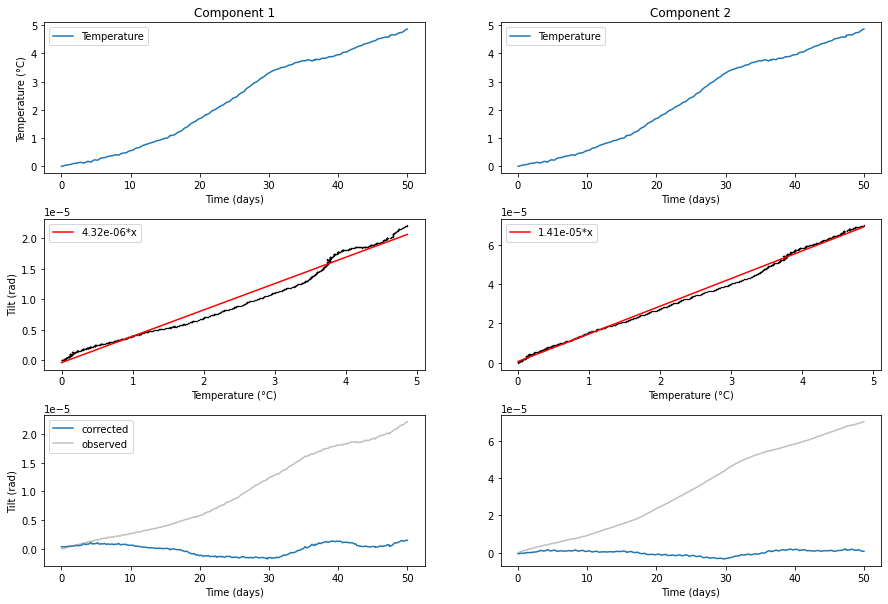

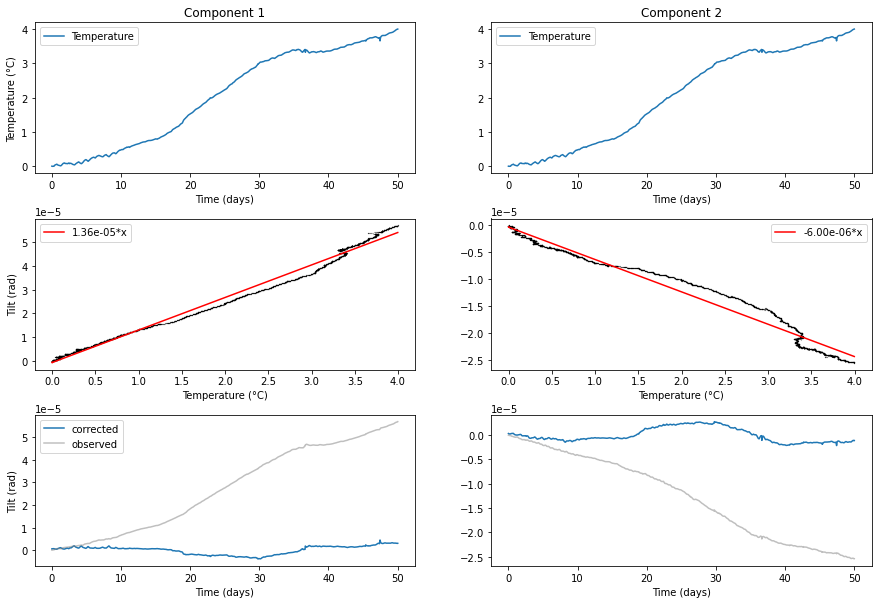

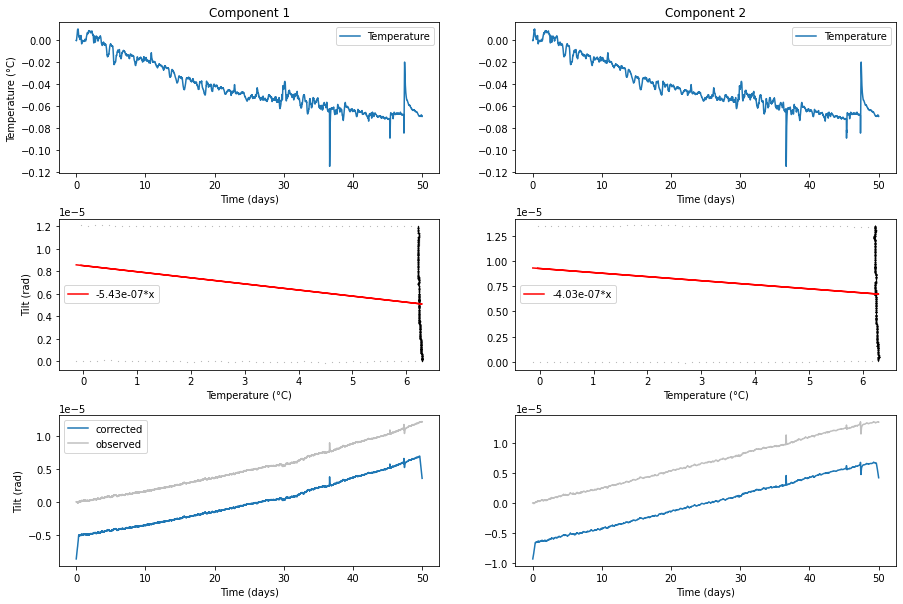

In [25]:
fig = __makeplot_compare(TROMY, out_tromy.get('slope'), out_tromy.get('intercept'), 
                         relative=True, derive=False, smooth=None);
# __savefig(fig, outpath=config['output_figures'], outname="TROMY_TemperatureCorrection_49days", mode="png", dpi=300)

fig = __makeplot_compare(ROMYT, out_romyt.get('slope'), out_romyt.get('intercept'), 
                         relative=True, derive=False, smooth=None);
# __savefig(fig, outpath=config['output_figures'], outname="ROMYT_TemperatureCorrection_49days", mode="png", dpi=300)

fig = __makeplot_compare(BROMY, out_bromy.get('slope'), out_bromy.get('intercept'), 
                         relative=True, derive=False, smooth=100);
# __savefig(fig, outpath=config['output_figures'], outname="BROMY_TemperatureCorrection_49days", mode="png", dpi=300)

## Get Temperature Coefficients for 2 Temperatures

In [184]:
def __makeplot_compare2(st, correction, derive=None, poly=None, smooth=None, coeff=None, relative=None):
    
    st0 = st.copy()
    
    N_trace = st0.select(channel="*N")[0]
    E_trace = st0.select(channel="*E")[0]
    T_trace = st0.select(channel="*T")[0]
    W_trace = st0.select(channel="WS*")[0]
    
    T_raw = T_trace
    W_raw = W_trace
        
    font = 14
    
    time_scaling = 86400  # days
    time_unit = "days"
    tilt_scaling = 1e6    # mirco rad
    tilt_unit = r"$\mu$rad"
    
    x_temp = T_trace.data
    w_temp = W_trace.data
    
    if relative:
        x_temp -= x_temp[0]
        w_temp -= w_temp[0]
        
    if derive:
        x_temp = np.gradient(x_temp, 2)
        w_temp = np.gradient(w_temp, 2)
        
    if smooth is not None:
        x_temp = __smooth(x_temp, smooth)
        w_temp = __smooth(w_temp, smooth)

        
        
    ## -----------------------
    
    fig, ax = plt.subplots(3, 2, figsize=(15,10))

    plt.subplots_adjust(hspace=0.3)

    ax[0][0].plot(T_raw.times()/time_scaling, T_raw.data, color="darkblue", label="Temperature T")
    ax[0][0].plot(W_raw.times()/time_scaling, W_raw.data, color="red", label="Temperature W")

    
    if derive:
        axes1 = ax[0][0].twinx()
        axes1.plot(T_trace.times()/time_scaling, x_temp, 'g', ls="--", label="dT/dt")
    
    ax[0][1].plot(T_trace.times()/time_scaling, T_raw, color="darkblue", label="Temperature T")
    ax[0][1].plot(W_trace.times()/time_scaling, W_raw, color="r", label="Temperature W")
   
    if derive:
        axes2 = ax[0][1].twinx()
        axes2.plot(T_trace.times()/time_scaling, x_temp, 'g', ls="--", label="dT/dt")
    
    for i in range(2):
        
        if i == 0: 
            trace = N_trace
        elif i == 1:
            trace = E_trace        
        
        ax[1][i].plot(x_temp, trace.data*tilt_scaling, '.', color="darkblue", ms=0.2)
        ax[1][i].plot(w_temp, trace.data*tilt_scaling, '.', color="red", ms=0.2)

        if not poly:        
#             ax[1][i].plot(x_temp, (correction['MAT']['slope'][i]*x_temp)*tilt_scaling, 'b', alpha=0.6, label=f"T: {correction['MAT']['slope'][i]:.2e}*x")
#             ax[1][i].plot(w_temp, (correction['WSX']['slope'][i]*w_temp)*tilt_scaling, 'r', alpha=0.6, label=f"W: {correction['WSX']['slope'][i]:.2e}*x")
            
            ax[1][i].plot(x_temp, (correction['MAT']['slope'][i]*x_temp + correction['MAT']['intercept'][i])*tilt_scaling, 'darkblue', alpha=0.6, label=f"T: {correction['MAT']['slope'][i]:.2e}*x")
            ax[1][i].plot(w_temp, (correction['WSX']['slope'][i]*w_temp + correction['WSX']['intercept'][i])*tilt_scaling, 'red', alpha=0.6, label=f"W: {correction['WSX']['slope'][i]:.2e}*x")
        
    
            T_correction_apply = correction['MAT']['slope'][i] * T_raw.data
            W_correction_apply = correction['WSX']['slope'][i] * W_raw.data

            ax[2][i].plot(trace.times()/time_scaling, (trace.data - T_correction_apply)*tilt_scaling, label="corrected T", color="darkblue")
            ax[2][i].plot(trace.times()/time_scaling, (trace.data - W_correction_apply)*tilt_scaling, label="corrected W", color="red")

            if i == 0:
                ax2_1 = ax[2][i].twinx()
                ax2_1.plot(trace.times()/time_scaling, trace.data*tilt_scaling, color='darkgreen', ls="--", alpha=0.7, label="observed")
                ax2_1.spines['right'].set_color("darkgreen")
#                 ax2_1.set_ylabel(f"raw Tilt ({tilt_unit})", fontsize=font, color="darkgreen")
                [label.set_color("darkgreen")  for label in ax2_1.get_yticklabels()]
            if i == 1:
                ax2_2 = ax[2][i].twinx()
                ax2_2.plot(trace.times()/time_scaling, trace.data*tilt_scaling, color='darkgreen', ls="--", alpha=0.7, label="observed")
                ax2_2.spines['right'].set_color("darkgreen")
                ax2_2.set_ylabel(f"raw Tilt ({tilt_unit})", fontsize=font, color="darkgreen")
                [label.set_color("darkgreen")  for label in ax2_2.get_yticklabels()]
                
        else: 
            ax[1][i].plot(x_temp, ffit[i], 'r')
            ax[2][i].plot(trace.times()/time_scaling, trace.data*tilt_scaling - poly[i], label="corrected")
            
            if i == 0:
                ax2_1 = ax[2][i].twinx()
                ax2_1.plot(trace.times()/time_scaling, trace.data*tilt_scaling - coeff[i][0], color='grey', alpha=0.8, label="observed")
            
        ax[0][i].set_title(f"{trace.stats.channel[-1]}-Component")
    
    
    if derive:
        ax[1][0].set_xlabel("Derivative of Temperature (°C)", fontsize=font)
        ax[1][1].set_xlabel("Derivative of Temperature (°C)", fontsize=font)
    else:
        ax[1][0].set_xlabel("Temperature (°C)", fontsize=font)
        ax[1][1].set_xlabel("Temperature (°C)", fontsize=font)
        
    ax[0][0].set_xlabel(f"Time ({time_unit})", fontsize=font)
    ax[0][1].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    ax[2][0].set_xlabel(f"Time ({time_unit})", fontsize=font)
    ax[2][1].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    ax[0][0].set_ylabel(f"Temperature (°C)", fontsize=font)
    
    ax[1][0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax[2][0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)

#     ax[2][0].set_ylim(-3,3)
#     ax[2][1].set_ylim(-3,3)
    
    ax[0][1].legend(fontsize=font-2)
    ax[0][0].legend(fontsize=font-2)
    ax[1][0].legend(fontsize=font-2)
    ax[1][1].legend(fontsize=font-2)
    ax[2][0].legend(fontsize=font-2)
   
    if derive:
        axes1.legend()
        axes2.legend()
        axes2.set_ylabel("dT/dt ")
    
    del st0
    
    plt.show();
    return fig

In [185]:
def __estimate_linear_trend2(st, derive=None, smooth=None, relative=None):
    
    st0 = st.copy()
    
    from scipy.stats import linregress
    
    T_temp = st0.select(channel="*T")[0].data
    W_temp = st0.select(channel="WS*")[0].data
    
    if relative:
        T_temp -= T_temp[0]
        W_temp -= W_temp[0]
        
    if derive:
        T_temp = np.gradient(T_temp, 2)
        W_temp = np.gradient(W_temp, 2)
        
    if smooth is not None:
        T_temp = __smooth(T_temp, smooth)
        W_temp = __smooth(W_temp, smooth)
        
        plt.plot(T_temp[smooth:-smooth])

    ## compute linear regression of data
    if smooth is not None:
        out1 = linregress(T_temp[smooth:-smooth], st0.select(channel="*N")[0].data[smooth:-smooth])
        out2 = linregress(T_temp[smooth:-smooth], st0.select(channel="*E")[0].data[smooth:-smooth])    
    else:
        out1 = linregress(T_temp, st0.select(channel="*N")[0].data)
        out2 = linregress(T_temp, st0.select(channel="*E")[0].data)
    
    ## prepare output dictionary
    output = {}
    output['MAT'] = {}
    output['MAT']['slope'] = [out1.slope, out2.slope]
    output['MAT']['intercept'] = [out1.intercept, out2.intercept]
    

    ## compute linear regression of data
    if smooth is not None:
        out1 = linregress(W_temp[smooth:-smooth], st0.select(channel="*N")[0].data[smooth:-smooth])
        out2 = linregress(W_temp[smooth:-smooth], st0.select(channel="*E")[0].data[smooth:-smooth])    
    else:
        out1 = linregress(W_temp, st0.select(channel="*N")[0].data)
        out2 = linregress(W_temp, st0.select(channel="*E")[0].data)
        
    output['WSX'] = {}
    output['WSX']['slope'] = [out1.slope, out2.slope]
    output['WSX']['intercept'] = [out1.intercept, out2.intercept]
    
    del st0
    
    return output

{'MAT': {'slope': [4.3178419010996744e-06, 1.4137832002201626e-05], 'intercept': [-3.6891454298812195e-07, 5.9211176777942937e-07]}, 'WSX': {'slope': [4.516135210125866e-06, 1.4865671741594365e-05], 'intercept': [-8.8913855658606314e-08, 1.3354357164149542e-06]}} 

{'MAT': {'slope': [1.3637171164446e-05, -6.0020566540739851e-06], 'intercept': [-5.4692274532764127e-07, -3.398753402896673e-07]}, 'WSX': {'slope': [1.0724801335790126e-05, -4.6674666386216503e-06], 'intercept': [-2.1650999461960714e-07, -6.210883870795188e-07]}} 

{'MAT': {'slope': [-0.00014085579818734752, -0.0001702032689641802], 'intercept': [-9.9287125643041744e-07, -5.9325639142973771e-07]}, 'WSX': {'slope': [6.2092170023483493e-05, 7.2930642705429399e-05], 'intercept': [9.3226316383822364e-08, 8.8768246621042301e-07]}} 



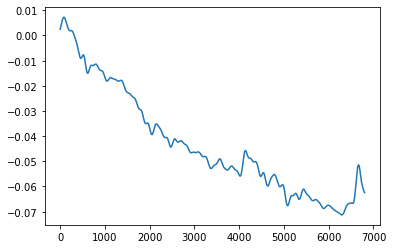

In [186]:
## compute linear regression 

out_tromy = __estimate_linear_trend2(TROMY, derive=False, smooth=None, relative=True)
print(out_tromy, "\n")

out_romyt = __estimate_linear_trend2(ROMYT, derive=False, smooth=None, relative=True)
print(out_romyt, "\n")

out_bromy = __estimate_linear_trend2(BROMY, derive=False, smooth=200, relative=True)
print(out_bromy, "\n")

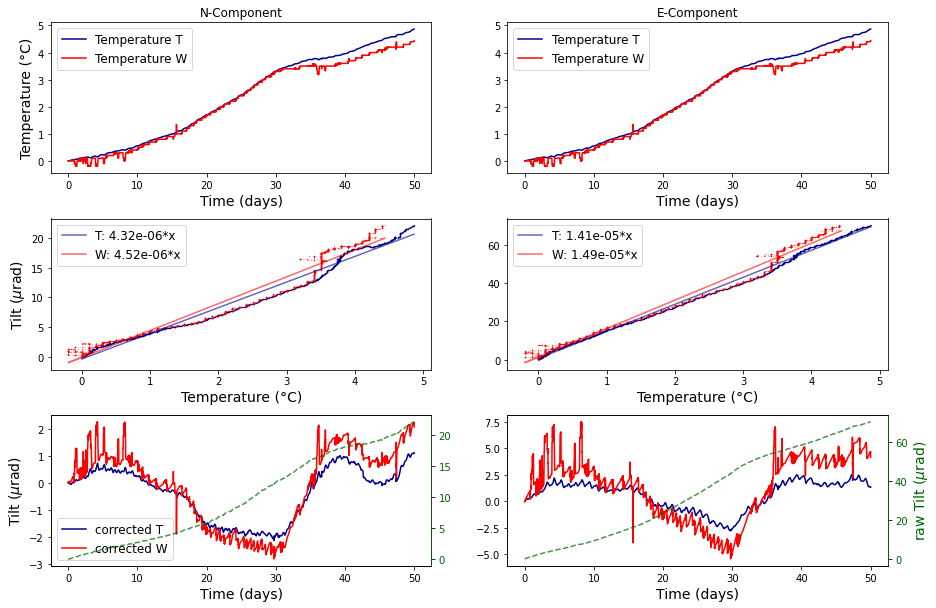


   -> saving /home/brotzer/Documents/ROMY/tiltmeter/figures/TROMY_TemperatureCorrection_T_vs_W.png ...

   -> Done



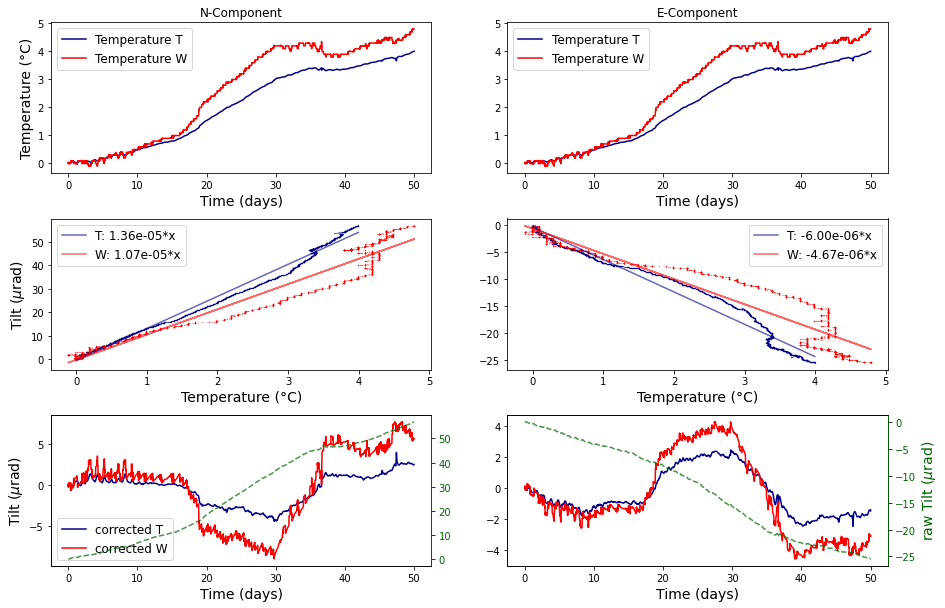


   -> saving /home/brotzer/Documents/ROMY/tiltmeter/figures/ROMYT_TemperatureCorrection_T_vs_W.png ...

   -> Done



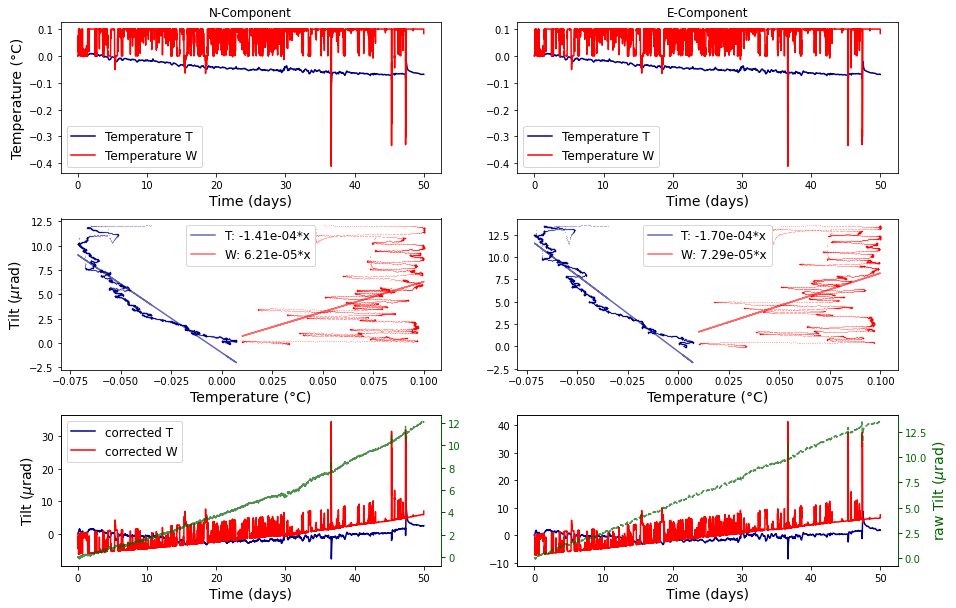

In [187]:
fig = __makeplot_compare2(TROMY, out_tromy, derive=False, smooth=None, relative=True);
__savefig(fig, outpath=config['output_figures'], outname="TROMY_TemperatureCorrection_T_vs_W", mode="png", dpi=300)

fig = __makeplot_compare2(ROMYT, out_romyt, derive=False, smooth=None, relative=True);
__savefig(fig, outpath=config['output_figures'], outname="ROMYT_TemperatureCorrection_T_vs_W", mode="png", dpi=300)

fig = __makeplot_compare2(BROMY, out_bromy, derive=False, smooth=200, relative=True);
# __savefig(fig, outpath=config['output_figures'], outname="BROMY_TemperatureCorrection_T_vs_W", mode="png", dpi=300)

In [ ]:
# BROMY.select(channel="WS1")[0].plot();
# BROMY.select(channel="LAT")[0].plot();

## Write to YML file 

In [193]:
# # # Write to yaml
# temp_record = "MAT"

# correction = {"TROMY":  {"N_slope": float(out_tromy[temp_record]['slope'][0]),
#                          "E_slope": float(out_tromy[temp_record]['slope'][1]),
#                          "N_intercept": float(out_tromy[temp_record]['intercept'][0]),
#                          "E_intercept": float(out_tromy[temp_record]['intercept'][1]),},
#              "ROMYT":   {"N_slope": float(out_romyt[temp_record]['slope'][0]),
#                         "E_slope": float(out_romyt[temp_record]['slope'][1]),
#                         "N_intercept": float(out_romyt[temp_record]['intercept'][0]),
#                         "E_intercept": float(out_romyt[temp_record]['intercept'][1]),},
#              "BROMY":   {"N_slope": float(out_bromy[temp_record]['slope'][0]),
#                         "E_slope": float(out_bromy[temp_record]['slope'][1]),
#                         "N_intercept": float(out_bromy[temp_record]['intercept'][0]),
#                         "E_intercept": float(out_bromy[temp_record]['intercept'][1]),},
#              }

# with open('tiltmeter_temperature_correction_tmp.yml', 'w') as file:
#     yaml.dump(correction, file)

## Correct for linear temperature effect on components

In [ ]:
def __correct_temperature_trend(st, correction):
    
    st0 = st.copy()
    temperature = st0.select(channel="*T")[0].data
    
    st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
    st0.select(channel="*E")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
    
    return st0

In [ ]:
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction.yml")

TROMY_temp_corrected = __correct_temperature_trend(TROMY, temperature_correction['TROMY'])
TRII_temp_corrected  = __correct_temperature_trend(TRII, temperature_correction['ROMYT'])

In [ ]:
fig = __makeplot(TROMY_temp_corrected, TRII_temp_corrected, config);